# Introduction

[Kitti](http://www.cvlibs.net/datasets/kitti/) dataset is one of the most well-known dataset in the field of automous driving, consiting of real-world, high resolution images for various computer vision tasks such as 2D/ 3D object detection. 

![Kitti Sample Image](./datasets/kitti_single/training/image_2/000050.png)

<br> In this tutorial, we will build a 2D object detection model using Kitti on [Azure AutoML for Images](https://techcommunity.microsoft.com/t5/azure-ai/announcing-automated-ml-automl-for-images/ba-p/2843034) platform. We will walk you through the journey from dataset preparation, submit runs on Azure AutoML for Images platform, and conduct result analysis. 

**Table of Content**

    0. Kitti Dataset Preparation
    1. Explorative Analysis on Kitti Dataset
    2. Conduct Default Runs on Azure AutoML for Images Platform
    3. Metrics Analysis & Tunings
    4. Error Analysis of 

In [1]:
from utils.data_utils import *

## Kitti Dataset

### Download Kitti Dataset

1. Download via [Object Detection Evaluation 2012](http://www.cvlibs.net/datasets/kitti/eval_object.php?obj_benchmark=2d) page: `Download left color images of object data set (12 GB)`, `Download training labels of object data set (5 MB)`& `Download object development kit (1 MB)`; 
2. unzip;
3. organize in current repository in the following fashion:


    .
    ├── 0.Kitti_Dataset_Preparation.ipynb
    ├── datasets                
    │   ├── kitti_single   
    │   │   ├── training          # training data
    │   │   │   ├── image_2
    │   │   │   │   ├── 000000.png
    │   │   │   ├── label_2
    │   │   │   │   ├── 000000.txt
    │   │   └── testing           # testing data
    │   │   │   ├── image_2
    │   │   └── devkit_object     
    │   │   │   ├── readme.txt
    └── ...

In [2]:
def get_label_fnames(label_root = "datasets/kitti_single/training/label_2/"):
    return [os.path.join(label_root, label_fname) \
                        for label_fname in os.listdir(label_root)\
                        if label_fname.endswith(".txt") ]

def get_image_fname(label_fname):
    return label_fname.replace("label_2", "image_2").replace(".txt", ".png")

label_fnames = get_label_fnames()
print("label_fname", label_fnames[0])
print("image_fname", get_image_fname(label_fnames[0]))

label_fname datasets/kitti_single/training/label_2/000000.txt
image_fname datasets/kitti_single/training/image_2/000000.png


### Understand labels

Below is a sample annotation for image `./datasets/kitti_single/training/label_2/000000.png`

In [3]:
label_fname = label_fnames[0]
def read_annotation(fname):
    with open(fname) as f:
        return f.read().strip("\n").split("\n")
    
rows = read_annotation(label_fname)
print(label_fname, rows)

datasets/kitti_single/training/label_2/000000.txt ['Pedestrian 0.00 0 -0.20 712.40 143.00 810.73 307.92 1.89 0.48 1.20 1.84 1.47 8.41 0.01']


What does that mean? <br>

As in `devkit_object/readme.txt`,

> The label files contain the following information. All values (numerical or strings) are separated via spaces,
each row corresponds to one object. The 15 columns represent:

     Values Name         Description
    ----------------------------------------------------------------------
       1    type         Describes the type of object: 'Car', 'Van', 
                         'Truck', 'Pedestrian', 'Person_sitting', 
                         'Cyclist', 'Tram', 'Misc' or 'DontCare'
       1    truncated    Float from 0 (non-truncated) to 1 (truncated), 
                         where truncated refers to the object 
                         leaving image boundaries
       1    occluded     Integer (0,1,2,3) indicating occlusion state:
                         0 = fully visible, 1 = partly occluded
                         2 = largely occluded, 3 = unknown
       1    alpha        Observation angle of object, ranging [-pi..pi]
       4    bbox         2D bounding box of object in the image 
                           (0-based index): contains left, top, 
                           right, bottom pixel coordinates
       3    dimensions   3D object dimensions: height, width, length 
                          (in meters)
       3    location     3D object location x,y,z in camera coordinates 
                          (in meters)
       1    rotation_y   Rotation ry around Y-axis in camera coordinates 
                           [-pi..pi]
       1    score        Only for results: Float, indicating confidence in
                         detection, needed for p/r curves, higher is better.
                         

In [4]:
# translate above readme to code

def parse_bbox_annotation(row: str):
    """
    obtain 2D object annotation
    """
    records = row.split(" ")
    bbox_label = {
        "type":records[0],
        "truncated":float(records[1]),
        "occluded":int(records[2]),
        "left":float(records[4]),
        "top":float(records[5]),
        "right":float(records[6]),
        "bottom":float(records[7]),
    }
    return bbox_label

def parse_annotation(fname: str):
    rows = read_annotation(fname)
    bbox_labels = [parse_bbox_annotation(row) for row in rows]
    return bbox_labels

bbox_labels = parse_annotation(label_fname)
bbox_labels

[{'type': 'Pedestrian',
  'truncated': 0.0,
  'occluded': 0,
  'left': 712.4,
  'top': 143.0,
  'right': 810.73,
  'bottom': 307.92}]

### Visualize Kitti Annotation

Let's visualize Kitti annotation to affirm our code logic.

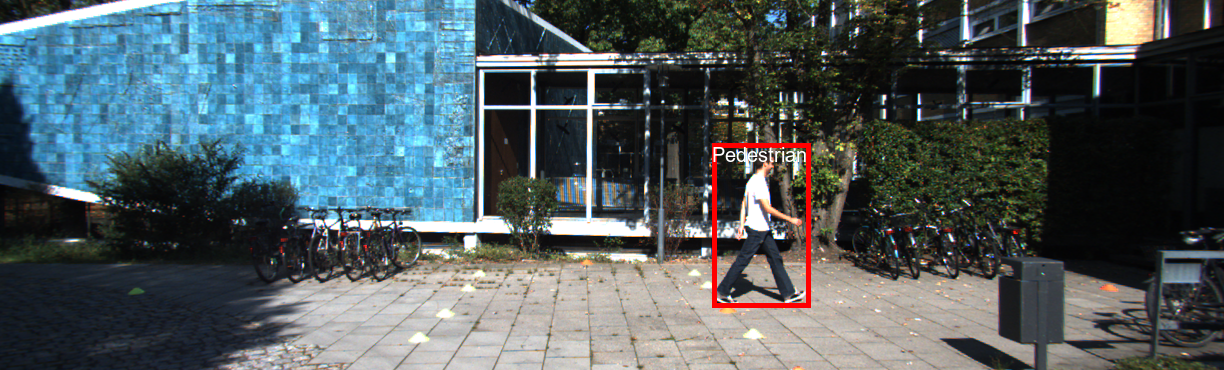

In [5]:
from utils.data_utils import *

font = ImageFont.truetype("./arial.ttf", size = 20)
def visualize(label_fname):
    bbox_labels = parse_annotation(label_fname)
    
    image_fname = get_image_fname(label_fname)
    image = Image.open(image_fname)
    draw = ImageDraw.Draw(image)
    
    for bbox in bbox_labels:
        draw.rectangle((bbox["left"], 
                        bbox["top"], 
                        bbox["right"], 
                        bbox["bottom"]), 
                        outline = "red", width = 5)
        draw.text((bbox["left"], bbox["top"]),
                   bbox["type"], align ="left",
                   font = font)
    display(image)
visualize(label_fname)

## Obtain Train, Validation DataFrames in a stratified fashion

Why do we need a stratified split? This is because, we don't want minority classes to accidentally overflow in either train - which reduce the representativity of validationd metrics, or validation - which gives too little training samples.

Unlike multi-class classification which one image corresponds to only one label, object detection dataset might have several bounding box labels on one image. Under this context, to conduct a [stratified](https://en.wikipedia.org/wiki/Stratified_sampling) train/validation split, we use [scikit-multilearn](http://scikit.ml/) to do multi-label stratification. 

In [6]:
# ! pip install scikit-multilearn
from sklearn.feature_extraction.text import CountVectorizer
from skmultilearn.model_selection import iterative_train_test_split

In [7]:
# get all annotations
def get_all_annotations():
    image_dfs = []
    for label_fname in label_fnames:
        bbox_labels = parse_annotation(label_fname)
        image_df = pd.DataFrame(bbox_labels)
        image_df["fname"] = get_image_fname(label_fname)
        image_dfs.append(image_df)
    return pd.concat(image_dfs, axis = 0)
df = get_all_annotations()
df.head()

,type,truncated,occluded,left,top,right,bottom,fname
0,Pedestrian,0.0,0,712.40,143.00,810.73,307.92,datasets/kitti_single/training/image_2/000000.png
0,Truck,0.0,0,599.41,156.40,629.75,189.25,datasets/kitti_single/training/image_2/000001.png
1,Car,0.0,0,387.63,181.54,423.81,203.12,datasets/kitti_single/training/image_2/000001.png
2,Cyclist,0.0,3,676.60,163.95,688.98,193.93,datasets/kitti_single/training/image_2/000001.png
3,DontCare,-1.0,-1,503.89,169.71,590.61,190.13,datasets/kitti_single/training/image_2/000001.png


In [8]:
# conver the object-detection dataframe into one-hot, multi-class like dataframe. 

binary_counts = df.pivot_table(index = "fname", columns = "type", 
                                         values = "left",aggfunc = "count" ).\
                            fillna(0).\
                            clip(0, 1)  # multiple occurance: 1
binary_counts.head()

type,Car,Cyclist,DontCare,Misc,Pedestrian,Person_sitting,Tram,Truck,Van
fname,,,,,,,,,
datasets/kitti_single/training/image_2/000000.png,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
datasets/kitti_single/training/image_2/000001.png,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
datasets/kitti_single/training/image_2/000002.png,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
datasets/kitti_single/training/image_2/000003.png,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
datasets/kitti_single/training/image_2/000004.png,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
train_fnames, _, validation_fnames, _ = iterative_train_test_split(
            binary_counts.index.to_numpy().reshape(-1, 1),
            binary_counts.to_numpy(),
            test_size = 0.2)

In [10]:
def get_df_by_fnames(fnames):
    fnames = set(fnames.reshape(-1))
    df_by_fnames = df[df["fname"].isin(fnames)]
    print(df_by_fnames.shape)
    return df_by_fnames

In [11]:
train_df = get_df_by_fnames(train_fnames)
train_df.head()

(41421, 8)


,type,truncated,occluded,left,top,right,bottom,fname
0,Truck,0.0,0,599.41,156.40,629.75,189.25,datasets/kitti_single/training/image_2/000001.png
1,Car,0.0,0,387.63,181.54,423.81,203.12,datasets/kitti_single/training/image_2/000001.png
2,Cyclist,0.0,3,676.60,163.95,688.98,193.93,datasets/kitti_single/training/image_2/000001.png
3,DontCare,-1.0,-1,503.89,169.71,590.61,190.13,datasets/kitti_single/training/image_2/000001.png
4,DontCare,-1.0,-1,511.35,174.96,527.81,187.45,datasets/kitti_single/training/image_2/000001.png


In [12]:
val_df = get_df_by_fnames(validation_fnames)
val_df.head()

(10444, 8)


,type,truncated,occluded,left,top,right,bottom,fname
0,Pedestrian,0.0,0,712.40,143.00,810.73,307.92,datasets/kitti_single/training/image_2/000000.png
0,Misc,0.0,0,804.79,167.34,995.43,327.94,datasets/kitti_single/training/image_2/000002.png
1,Car,0.0,0,657.39,190.13,700.07,223.39,datasets/kitti_single/training/image_2/000002.png
0,Car,0.0,0,280.38,185.10,344.90,215.59,datasets/kitti_single/training/image_2/000004.png
1,Car,0.0,0,365.14,184.54,406.11,205.20,datasets/kitti_single/training/image_2/000004.png


## Prepare in JSON format for Azure AutoML for Images

Azure AutoML for Images platform accepts [`TabularDataset`](https://docs.microsoft.com/en-us/python/api/azureml-core/azureml.data.tabulardataset?view=azure-ml-py) which is from either of :
1. From a [Labeled Project](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-create-image-labeling-projects#export-the-labels)
2. Directly from [Dataset with JSON annotations](https://github.com/Azure/azureml-examples/blob/main/python-sdk/tutorials/automl-with-azureml/image-object-detection/auto-ml-image-object-detection.ipynb#convert-the-downloaded-data-to-jsonl) on your Azure blob storage.

Below shows how we prepare JSON from our training and validation dataframe.


In [13]:
def convert_bbox(row, width, height):
    bbox_dict = dict()
    bbox_dict["label"] = row["type"]
    bbox_dict["topX"] = row["left"]/ width
    bbox_dict["topY"] = row["top"]/ height
    bbox_dict["bottomX"] = (row["right"])/ width
    bbox_dict["bottomY"] = (row["bottom"])/ height
    bbox_dict['isCrowd'] = 0
    bbox_dict["isTruncated"] = str(row["truncated"] != 0).lower()
    bbox_dict["mask"] = ""
    return bbox_dict
    
def convert_image(image_fname, image_df, imagesblobstore = "AmlDatastore://"):
    annotation_dict = dict()    
    annotation_dict["image_details"] = dict()
    annotation_dict["label"] = []

    image = Image.open(image_fname)
    width, height = image.size
       
    annotation_dict["image_url"] = imagesblobstore + image_fname
    annotation_dict["image_details"]["format"] = os.path.splitext(image_fname)[-1][1:]
    annotation_dict["image_details"]["width"] = str(width) + "px"
    annotation_dict["image_details"]["height"] = str(height) + "px"

    for _, row in image_df.iterrows():
        annotation_dict["label"].append(
            convert_bbox(row, width, height))
    return annotation_dict

def convert_df(df_by_train_type, json_fname):
    annotation_list = []
    for image_fname, image_df in df_by_train_type.groupby("fname"):
        annotation_dict = convert_image(image_fname, image_df)
        annotation_list.append(annotation_dict)
    save_jsonl(json_fname = json_fname, 
               annotation_list = annotation_list)

In [14]:
convert_df(train_df, "./datasets/kitti_single/train.json")

In [15]:
convert_df(val_df, "./datasets/kitti_single/val.json")

## Input Validation

TODO: plan to add a `InputValidator` class to ensure json format is correct by checking:

    1. there's bounding boxes per image
    2. there's topX etc. in bbox
    3. No all isCrowd category (isTruncated?)
    4. min areas of bbox

## (Optional: DontCare class)
TODO - don't read on as they are random code blocks at this moment

In [16]:
# json_parser = JsonParser("OD")
# # train_df = json_parser.parse("./data/kitti_single/kitti_train_sub.jsonl")
# train_df.head()

In [17]:
# train_df_normal = train_df[train_df["label"] != "DontCare"]
# train_df_normal.shape

In [18]:
# train_df_dontcare = train_df[train_df["label"] == "DontCare"]
# train_df_dontcare.shape

In [19]:
# def calc_iou(bbox_non_crowd, bbox_is_crowd):
#     b1_x1, b1_x2 = bbox_non_crowd["topX"], bbox_non_crowd["bottomX"]
#     b1_y1, b1_y2 = bbox_non_crowd["topY"], bbox_non_crowd["bottomY"]

#     b2_x1, b2_x2 = bbox_is_crowd["topX"], bbox_is_crowd["bottomX"]
#     b2_y1, b2_y2 = bbox_is_crowd["topY"], bbox_is_crowd["bottomY"]
    
#     inter = max(min(b1_x2, b2_x2) - max(b1_x1, b2_x1), 0) * \
#             max(min(b1_y2, b2_y2) - max(b1_y1, b2_y1), 0)
    
#     union = (b1_x2 - b1_x1) * (b1_y2 - b1_y1) # non_crowd region
#     return inter/union
# bbox_non_crowd = train_df_normal.iloc[0]
# bbox_is_crowd = train_df_dontcare.iloc[0]
# print("iou = ", calc_iou(bbox_non_crowd, bbox_is_crowd))
# print(bbox_non_crowd, bbox_is_crowd)

In [20]:
# # based on fname:
# # calculate iou with every of non_crowd
# # get maximum number
# import collections
# non_zero_ious = collections.defaultdict(list)
# for fname in train_df_dontcare["fname"].unique():
#     # obtain subset of normal bounding boxes
#     normal_bboxes = train_df_normal[train_df_normal["fname"] == fname]
#     dontcare_bboxes = train_df_dontcare[train_df_dontcare["fname"] == fname]
#     for _, bbox_is_crowd in dontcare_bboxes.iterrows():
#         for _, bbox_non_crowd in normal_bboxes.iterrows():
#             iou = calc_iou(bbox_non_crowd, bbox_is_crowd)
#             if iou > 0 and not bbox_non_crowd["isCrowd"]:
#                 non_zero_ious[fname].append(iou)

In [21]:
# non_zero_ious

In [22]:
# cnt = 0
# for key, iou_list in non_zero_ious.items():
#     if max(iou_list) >= 0.5:
#         print(key, iou_list)
#         cnt += 1
# print(cnt)

In [23]:
# def plot_bbox(fname):
#     print(fname, non_zero_ious[fname])
#     od_df_sub = train_df[train_df["fname"] == fname]
#     image = Image.open(fname)
#     draw = ImageDraw.Draw(image)
#     font = ImageFont.truetype("./arial.ttf", size = 25)

#     for _, row in od_df_sub.iterrows():
#         if row["label"] == "DontCare":
#             color = "black"
#         else:
#             color = "red"
#         draw.rectangle((row["topX"], 
#                         row["topY"], 
#                         row["bottomX"], 
#                         row["bottomY"]), 
#                         outline = color, width = 5)
#         draw.text((row["topX"], row["topY"],),
#                 row["label"], align ="left", font = font, fill = color)
#     return image


In [24]:
# plot_bbox("datasets/kitti_single/training/image_2/002520.png")

In [25]:
# plot_bbox("datasets/kitti_single/training/image_2/005984.png")

In [26]:
# plot_bbox("datasets/kitti_single/training/image_2/000668.png")